In [49]:
import numpy as np
import pandas as pd
from pygimli.meshtools import readGmsh
import pygimli as pg

from scipy.spatial import distance_matrix
from scipy.interpolate import griddata
from itertools import combinations
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, cKDTree
from pygimli.physics import ert
from ertoolbox import inversion
from ertoolbox import ert_postprocessing


In [50]:
csv = '../data/crosssection_sal_tem_20220801_0000.csv'
data = pd.read_csv(csv)
print(data)



     Distance [m]   Z [m NAP]   Salinity [psu]   Temperature [degC]
0           12.99      -1.564             0.58                19.00
1           12.99      -1.503             0.58                19.00
2           12.99      -1.382             0.58                19.00
3           12.99      -1.260             0.58                19.00
4           12.99      -1.139             0.58                19.00
..            ...         ...              ...                  ...
563         98.94      -0.670             0.57                18.99
564         98.94      -0.544             0.57                18.99
565         98.94      -0.417             0.57                18.98
566         98.94      -0.291             0.57                18.96
567         98.94      -0.228             0.57                18.96

[568 rows x 4 columns]


In [51]:
data.columns =['x', 'z', 'salinity', 'temperature'] #for now these columns are nesseccary!!

In [52]:
data["resistivity"] = 1 / ert_postprocessing.salinity_to_conductivity(
        data["salinity"], data["temperature"]
    )

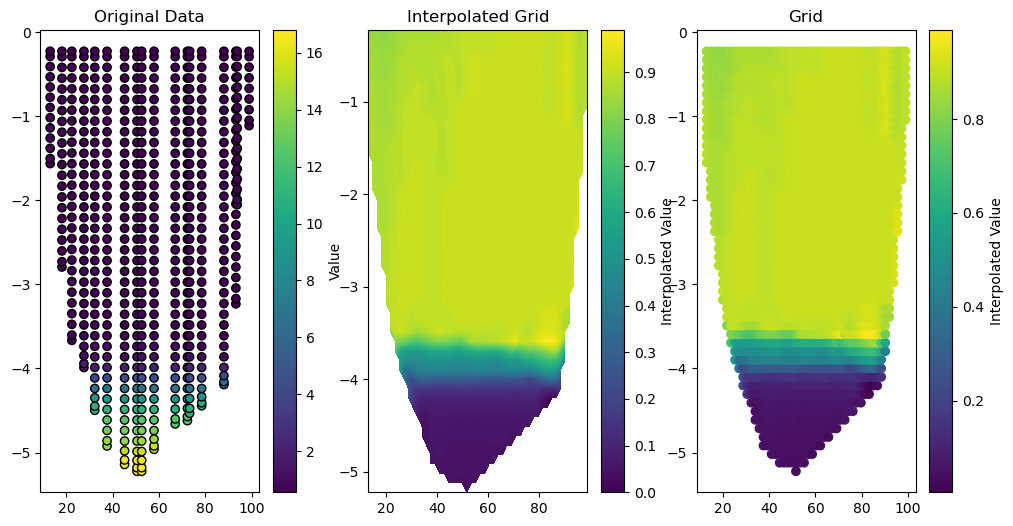

In [53]:
# Define grid parameters
x_min, x_max = data['x'].min(), data['x'].max()
z_min, z_max = data['z'].min(), data['z'].max()
grid_size = 50  # Number of grid points along each axis

# Create a regular grid
x_grid = np.linspace(x_min, x_max, grid_size)
z_grid = np.linspace(z_min, z_max, grid_size)
X_grid, Z_grid = np.meshgrid(x_grid, z_grid)
Y_grid = np.zeros(np.shape(X_grid))

# Stack grid data
xyz = np.column_stack([X_grid.flatten(),Z_grid.flatten()])

# Prepare data for interpolation
points = data[['x', 'z']].values
values = data['resistivity'].values

# Interpolate
grid_values = griddata(points, values, (X_grid, Z_grid), method='cubic')

# Plot original points
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(data['x'], data['z'], c=data['salinity'], cmap='viridis', edgecolor='k')
plt.title('Original Data')
plt.colorbar(label='Value')

# Plot interpolated grid
plt.subplot(1, 3, 2)
plt.contourf(X_grid, Z_grid, grid_values, levels=100, cmap='viridis')
plt.title('Interpolated Grid')
plt.colorbar(label='Interpolated Value')
# X_grid = data['x']
# Z_grid = data['z']
# grid_values = data['salinity']
plt.subplot(1, 3, 3)
plt.scatter(X_grid, Z_grid, c=grid_values)
plt.title('Grid')
plt.colorbar(label='Interpolated Value')
plt.show()

In [54]:
# Create a DataFrame
df = pd.DataFrame(
    {"x": X_grid.flatten(), "z": Z_grid.flatten(), "value": grid_values.flatten()}
)
from scipy import interpolate

# Only use valid data points
df = df.dropna()
# #take 1 node above the bottom
min_z_indices = df.groupby('x')['z'].idxmin()
df = df.drop(min_z_indices)
df.reset_index(drop=True, inplace=True)

min_z_indices = df.groupby("x")["z"].idxmin()
min_z_df = df.loc[min_z_indices]
min_z_df.reset_index(drop=True, inplace=True)

x_points = min_z_df['x']
z_points = min_z_df['z']
# Interpolation
distance = 1  # cm

# Calculate the distances between the original points
distances = np.sqrt(np.diff(x_points)**2 + np.diff(z_points)**2)

# Calculate cumulative distances
cumulative_distances = np.concatenate(([0], np.cumsum(distances)))

# New distance points from the start to the end
new_distances = np.arange(0, cumulative_distances[-1], distance)

# Interpolating
new_x = np.interp(new_distances, cumulative_distances, x_points)
new_z = np.interp(new_distances, cumulative_distances, z_points)

# Resulting interpolated points
interpolated_points = np.column_stack((new_x, new_z))


def calculate_distances(points):
    """
    Calculate distances between consecutive points.

    Parameters:
    points (array-like): A 2D array or list of points where each point is represented as [x, y].

    Returns:
    np.ndarray: An array of distances between consecutive points.
    """
    points = np.array(points)  # Ensure the input is a NumPy array
    # Calculate the distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
    return distances


distances = calculate_distances(interpolated_points)


16/10/24 - 12:17:32 - pyGIMLi - INFO - Data error estimate (min:max)  0.010018563281316326 : inf


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


16/10/24 - 12:17:32 - pyGIMLi - INFO - Found 1087 regions.
16/10/24 - 12:17:32 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (0) set to background.
16/10/24 - 12:17:32 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/10/24 - 12:17:32 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
16/10/24 - 12:17:32 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2222 Cells: 4348 Boundaries: 3308
16/10/24 - 12:17:32 - pyGIMLi - INFO - Use median(data values)=0.6853252161228968
16/10/24 - 12:17:32 - pyGIMLi - INFO - Created startmodel from forward operator: 1086, min/max=0.685325/0.685325
16/10/24 - 12:17:32 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000025E47925CB0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000025E47900540>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000025E45738590>
min/max (data): 1.5e-04/33.89
min/max (error): 1%/2.2e+05%
min/max (start model): 0.69/0.69
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 6069.01
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 5431.67 (dPhi = 10.27%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 5293.03 (dPhi = 2.53%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 5098.89 (dPhi = 3.60%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 4968.39 (dPhi = 2.55%) lam: 20.0
---------

16/10/24 - 12:19:01 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.Inversion'>.run(c:\Users\leentvaa\SaltSimulator\.pixi\envs\default\Lib\site-packages\pygimli\frameworks\inversion.py:723)
One step failed. Aborting and going back to last model


./core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
chi² = 4771.76 (dPhi = 0.00%) lam: 20.0
################################################################################
#                 Abort criterion reached: dPhi = 0.0 (< 2.0%)                 #
################################################################################


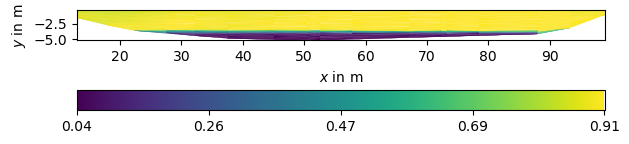

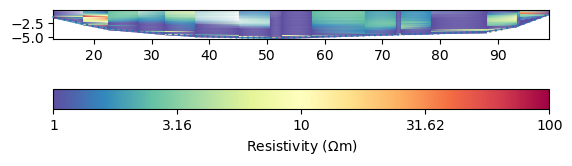

In [56]:
# Create 2D Pygimli  mesh
mesh = pg.Mesh(2)

cs = []
cr = []

# Make nodes for all datapoints
for p in points:
    c = mesh.createNode((p[0],p[1]))
    cs.append(c)

# # make nodes for all electrodes:
# for pt in interpolated_points:
#     c = mesh.createNode((pt[0],pt[1]))
#     cs.append(c)

# Triangulate points into mesh with triangles
tri = Delaunay(points)
triangles = tri.simplices

# Calculate centroids of the triangles
centroids = np.array([np.mean(points[tri.simplices[i]], axis=0) for i in range(len(tri.simplices))])

# Find closest grid point to the triangle
tree = cKDTree(points)
distances, indices = tree.query(centroids)

# Add value to the grid cell
triangle_values = values[indices]

# Add triangles to mesh object
tlist = []
for t in range(0,len(triangles)):
    mesh.createTriangle(cs[triangles[t][0]],cs[triangles[t][1]],cs[triangles[t][2]], marker = t)
    tlist = np.append(tlist,t)

# Add boundaries
mesh.createNeighborInfos()

# Plot mesh with values
ax, cb = pg.show(mesh, data=triangle_values)

# Define electrode positions TODO
EZ = new_z
EX = new_x
electrodes = [[x, y] for x, y in zip(EX, EZ)]

# Create measurement scheme
scheme_dd = ert.createData(elecs=electrodes, schemeName='dd')

# Make simulation data
simdata = ert.simulate(
         mesh=mesh, scheme=scheme_dd, res=triangle_values, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337
    )

simdata.remove(simdata["rhoa"] < 0)
#Inverse for check
inversion_dd_1 = inversion(simdata, mesh, saveresult=False)
